In [25]:
import pandas as pd
import numpy as np
#import pyarrow as pa
#import pyarrow.parquet as pq
import matplotlib.pyplot as plt
#from matplotlib import rcParams
import seaborn as sns
#import regex as re
#import networkx as nx
#import random
#from scipy.sparse import csr_matrix
#from scipy.spatial import distance
#from sklearn.decomposition import PCA
#from sklearn.impute import SimpleImputer
#from scipy.spatial.distance import cosine
#from sklearn.preprocessing import StandardScaler
#import os
#from tqdm import tqdm
#import plotly.graph_objects as go
#from PIL import Image
from scipy.stats import spearmanr

#from networkx.algorithms.community import louvain_communities
#from networkx.algorithms.community.quality import modularity

#from functions import calculate_monthly_velocities_cosine, get_similarities, get_matrix

In [26]:
stats_checkpoint_path = "stats_checkpoint.parquet"

In [27]:
stats_df = pd.read_parquet(stats_checkpoint_path)

### Plot merged stats values

In [28]:
def plot_combined_years(yearly_data, years, column_order):
    """
    yearly_data: dict of {year: (means_arr, stds_arr, consecutive_modularity_averages, consecutive_month_pairs)}
    years: list of years to plot
    column_order: list of all month-pair labels in order
    """
    # Concatenate data
    all_means = []
    all_stds = []
    all_modularities = []
    all_month_pairs = []
    for year in years:
        means_arr, stds_arr, modularity_avgs, month_pairs, sim_avg_std_per_month, sim_avg_mean_per_month = yearly_data[year]
        all_means.extend(means_arr)
        all_stds.extend(stds_arr)
        all_modularities.extend(modularity_avgs)
        all_month_pairs.extend([f"{year}-{mp}" for mp in month_pairs])

    fig, ax1 = plt.subplots(figsize=(24, 6))
    ax1.plot(all_month_pairs, all_modularities, marker='o', linestyle='-', color='purple', label='Avg. Modularity')
    ax1.set_xlabel('Year-Month Pair')
    ax1.set_ylabel('Average Modularity', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.set_xticks(range(len(all_month_pairs)))
    ax1.set_xticklabels(all_month_pairs, rotation=90)

    ax2 = ax1.twinx()
    ax2.plot(all_month_pairs, all_means, marker='o', linestyle='--', color='g', label='Mean Velocity')
    ax2.fill_between(range(len(all_month_pairs)), np.array(all_means) - np.array(all_stds), np.array(all_means) + np.array(all_stds), color='green', alpha=0.15, label='Velocity Mean ± Std. Dev.')
    ax2.set_ylabel('Velocity', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', bbox_to_anchor=(1.02, 0.5), borderaxespad=6)

    plt.title('Combined Years: Average Louvain Modularity, Similarity, and Velocity Statistics per Month Pair')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('combined_2018_2022_merged.png')
    plt.show()

In [29]:
# Define the desired column order
column_order = [
    'January-February', 'February-March', 'March-April', 'April-May', 
    'May-June', 'June-July', 'July-August', 'August-September', 
    'September-October', 'October-November', 'November-December'
]

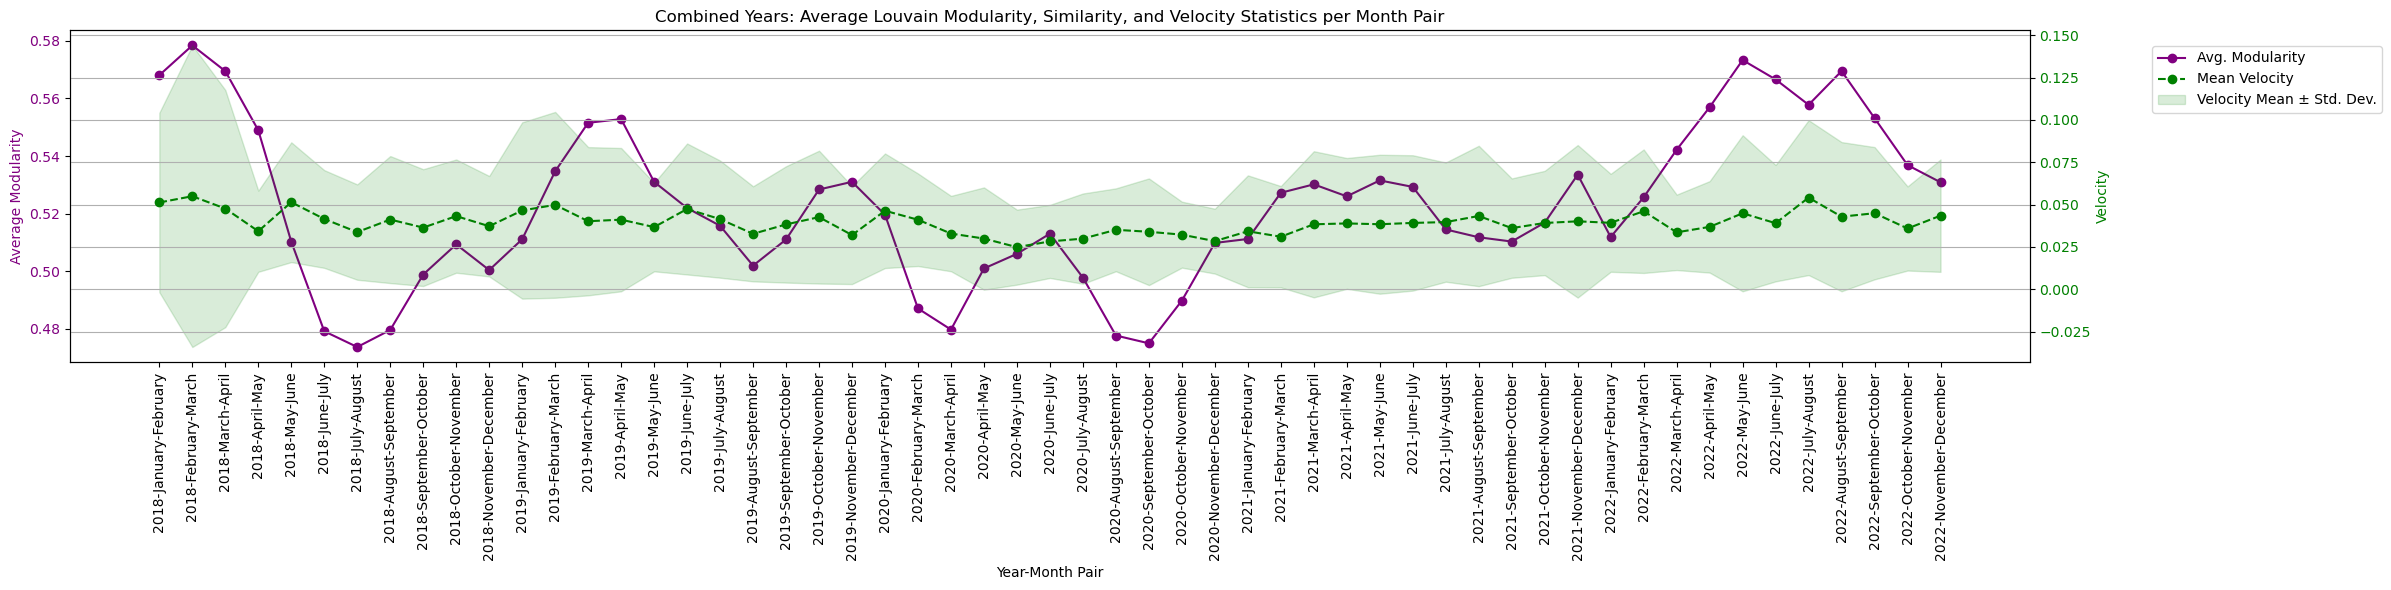

In [30]:
# Prepare data_per_year from stats_df
data_per_year = {}
for _, row in stats_df.iterrows():
    # Use column_order as the month_pairs for all years (or adapt if you have per-year pairs)
    data_per_year[row['year']] = (
        row['veloc_means_arr'],
        row['veloc_stds_arr'],
        row['consecutive_modularity_averages'],
        column_order,  # This is used as month_pairs
        row['sim_avg_std_per_month'],
        row['sim_avg_mean_per_month']
    )

# List of years to plot
years = list(stats_df['year'])

# Call the plotting function
plot_combined_years(data_per_year, years, column_order)

In [31]:
stats_df_copy = stats_df.copy()

In [32]:
stats_df_copy_renamed = stats_df_copy.rename(columns={
    'veloc_means_arr': 'Velocity Means',
    'veloc_stds_arr': 'Velocity STDs',
    'consecutive_modularity_averages': 'Modularity Average',
    'sim_avg_std_per_month': 'AVG STD of Similarity per Month',
    'sim_avg_mean_per_month': 'AVG Mean of Similarity per Month'
})

In [33]:
# Function to flatten column values to a list of floats
def flatten_column(col):
    flattened = []
    for val in col:
        if isinstance(val, dict):
            flattened.extend([float(v) for v in val.values()])
        elif isinstance(val, (list, np.ndarray)):
            flattened.extend([float(v) for v in val])
        else:
            flattened.append(float(val))
    return flattened

In [34]:
# Flatten and collect all columns except 'year'
flattened_cols = {}
for col in stats_df_copy_renamed.columns:
    if col == 'year':
        continue
    flattened_vals = flatten_column(stats_df_copy_renamed[col])
    flattened_cols[col] = flattened_vals

# Align by shortest length
min_len = min(len(v) for v in flattened_cols.values())
aligned_cols = {k: v[:min_len] for k, v in flattened_cols.items()}

# Build aligned DataFrame
flat_df = pd.DataFrame(aligned_cols)

# Compute Spearman correlation and p-values using scipy
corr_matrix, pval_matrix = spearmanr(flat_df)

# Convert to DataFrames for better readability
spearman_corr_df = pd.DataFrame(corr_matrix, index=flat_df.columns, columns=flat_df.columns)
spearman_pval_df = pd.DataFrame(np.round(pval_matrix, 4), index=flat_df.columns, columns=flat_df.columns)

In [35]:
display(spearman_corr_df)
display(spearman_pval_df)

,Velocity Means,Velocity STDs,Modularity Average,AVG STD of Similarity per Month,AVG Mean of Similarity per Month
Velocity Means,1.000000,0.788745,0.433983,-0.361688,-0.400000
Velocity STDs,0.788745,1.000000,0.532251,-0.255844,-0.302525
Modularity Average,0.433983,0.532251,1.000000,-0.206277,-0.310173
AVG STD of Similarity per Month,-0.361688,-0.255844,-0.206277,1.000000,0.871789
AVG Mean of Similarity per Month,-0.400000,-0.302525,-0.310173,0.871789,1.000000


,Velocity Means,Velocity STDs,Modularity Average,AVG STD of Similarity per Month,AVG Mean of Similarity per Month
Velocity Means,0.0000,0.0000,0.0009,0.0067,0.0025
Velocity STDs,0.0000,0.0000,0.0000,0.0594,0.0248
Modularity Average,0.0009,0.0000,0.0000,0.1308,0.0212
AVG STD of Similarity per Month,0.0067,0.0594,0.1308,0.0000,0.0000
AVG Mean of Similarity per Month,0.0025,0.0248,0.0212,0.0000,0.0000


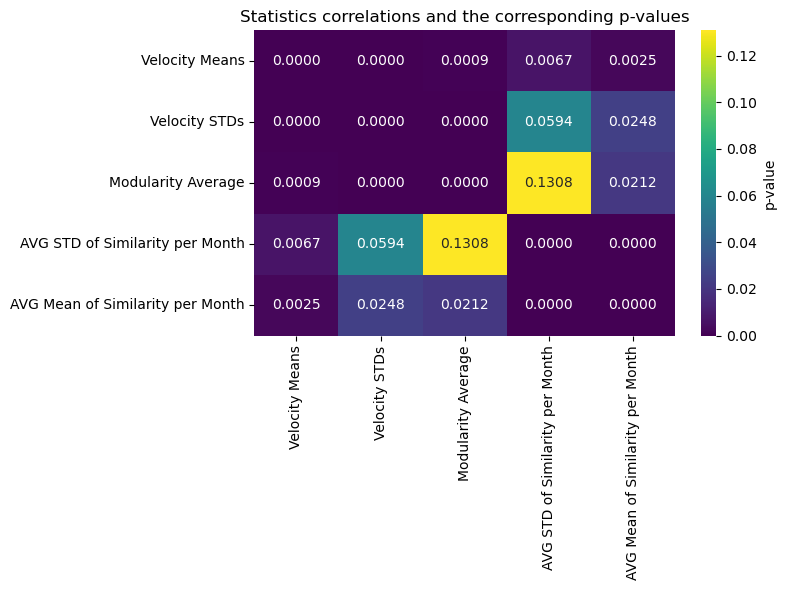

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    spearman_pval_df,
    annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'p-value'}
)
plt.title("Statistics correlations and the corresponding p-values")
plt.tight_layout()
plt.savefig('correlations_heatmap.png')
plt.show()